In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Add, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import load_model

In [4]:
# Load and preprocess data
def preprocess_data(train_dir, test_dir, image_size=(64, 64), batch_size=32):
    # Data augmentation for training set
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Only rescaling for test set
    test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    # Training generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    # Test generator (using directory with single image per class)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, test_generator

In [5]:
# Define a residual block
def residual_block(x, filters):
    """Creates a residual block."""
    shortcut = x
    # First convolution layer
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution layer
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # Add the shortcut to the block
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Create the hybrid model with residual blocks
def create_hybrid_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Block 1: Simple Conv + Residual
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)

    # Residual Block 1
    x = residual_block(x, 32)

    # Block 2: VGG-style Conv + Residual
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Residual Block 2
    x = residual_block(x, 64)

    # Block 3: Deeper Convolutions + Residual
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    # Residual Block 3
    x = residual_block(x, 128)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [6]:
# hyperparameters
train_dir = "ASL_dataset/asl_alphabet_train"
test_dir = "ASL_dataset/asl_alphabet_test"
input_shape = (64, 64, 3)
num_classes = 29  # 26 letters + 3 special classes
num_epoch=20

In [7]:
# Data preparation
train_generator, test_generator = preprocess_data(train_dir, test_dir)

# Create model
model = create_hybrid_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)

# Training the model
history = model.fit(
    train_generator,
    epochs=num_epoch,  # Increase epochs for better training
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)
# Evaluation on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Classification Report
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))



Found 87000 images belonging to 29 classes.
Found 29 images belonging to 29 classes.
Epoch 1/20


2024-11-01 15:59:31.671545: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/iiserb2/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2719/2719 ━━━━━━━━━━━━━━━━━━━━ 178s 65ms/step - accuracy: 0.1765 - loss: 2.7325 - val_accuracy: 0.7586 - val_loss: 0.5786
Epoch 2/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 179s 66ms/step - accuracy: 0.7585 - loss: 0.6899 - val_accuracy: 1.0000 - val_loss: 0.0391
Epoch 3/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 180s 66ms/step - accuracy: 0.8739 - loss: 0.3851 - val_accuracy: 1.0000 - val_loss: 0.0437
Epoch 4/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 178s 66ms/step - accuracy: 0.9151 - loss: 0.2739 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 5/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 180s 66ms/step - accuracy: 0.9342 - loss: 0.2099 - val_accuracy: 1.0000 - val_loss: 0.0204
Epoch 6/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 177s 65ms/step - accuracy: 0.9436 - loss: 0.1823 - val_accuracy: 0.9655 - val_loss: 0.1293
Epoch 7/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 177s 65ms/step - accuracy: 0.9521 - loss: 0.1596 - val_accuracy: 1.0000 - val_loss: 0.0085
Epoch 8/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 177s 65ms/step - accuracy: 0.9562 - lo

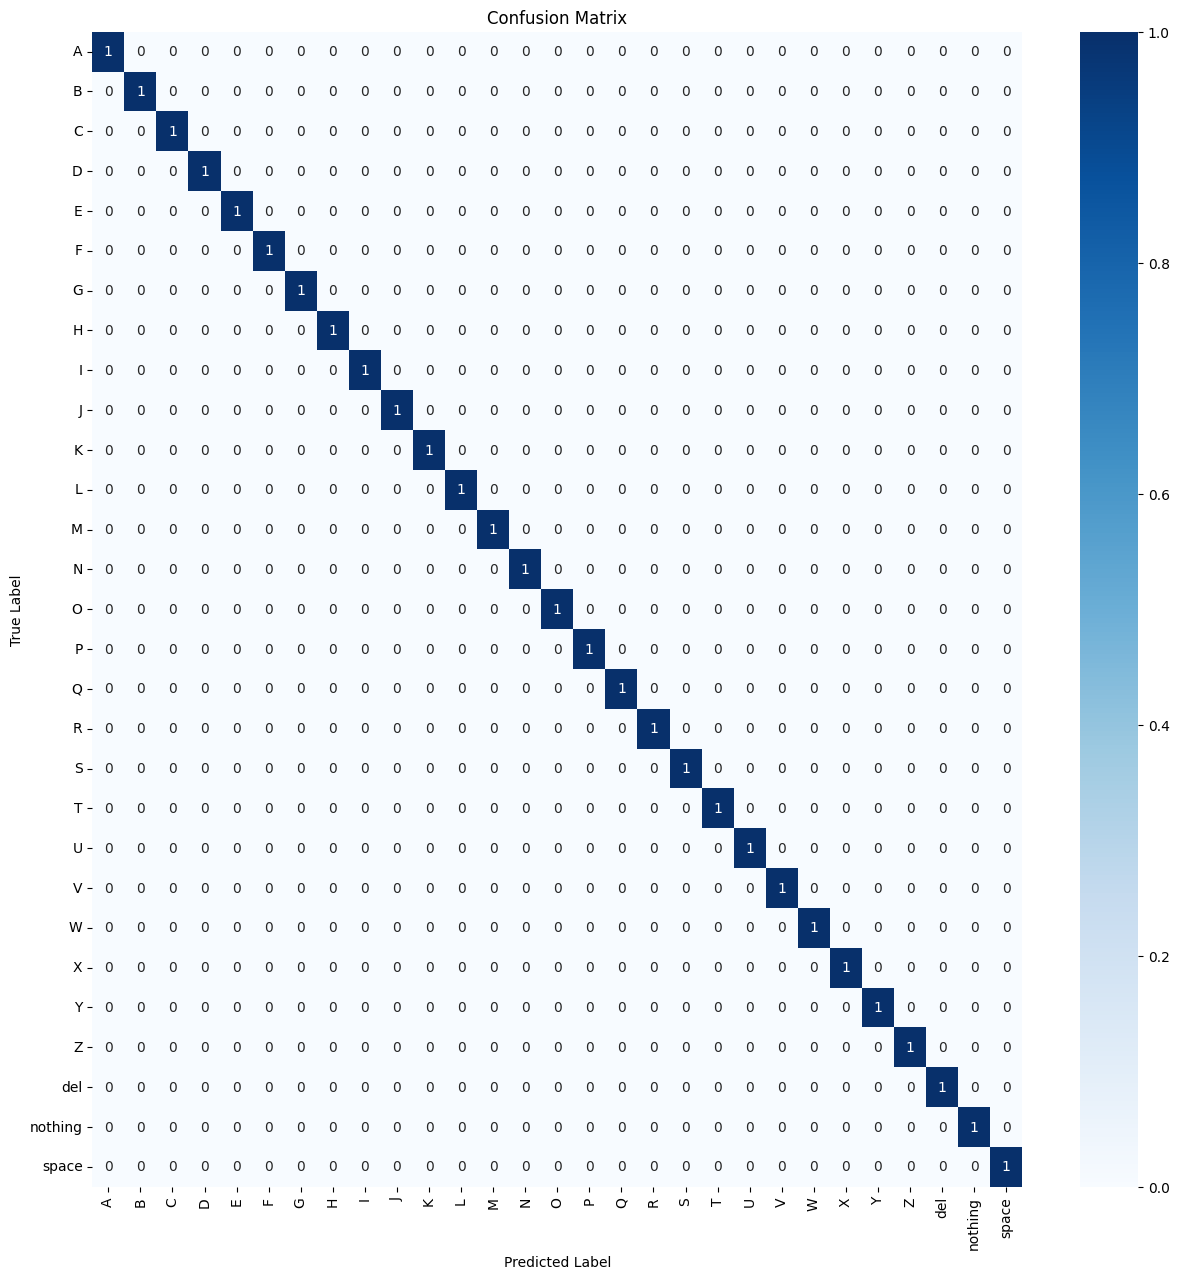

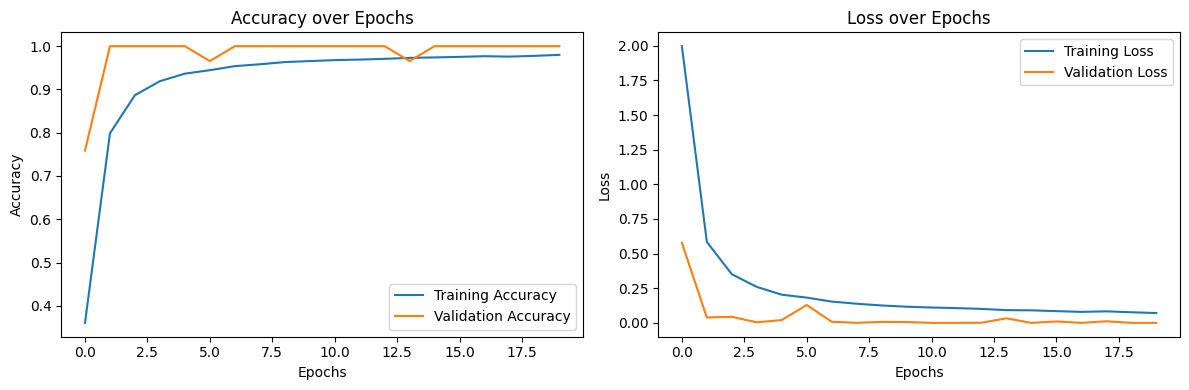

In [8]:
# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plotting training results
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


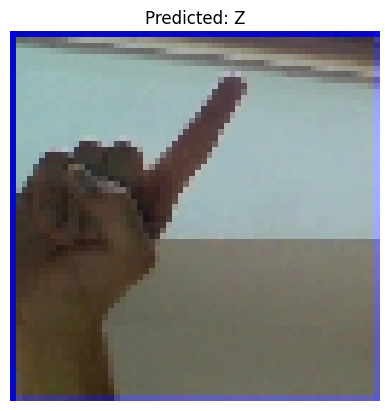

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


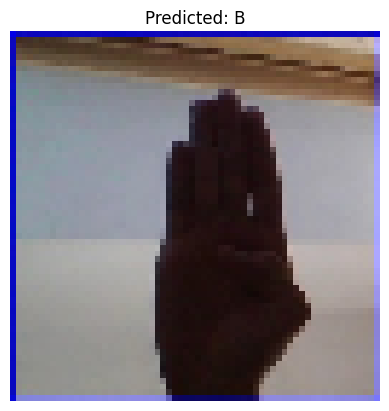

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


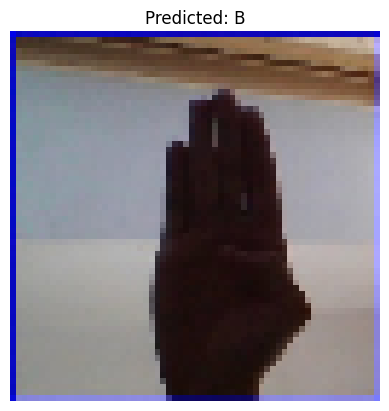

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


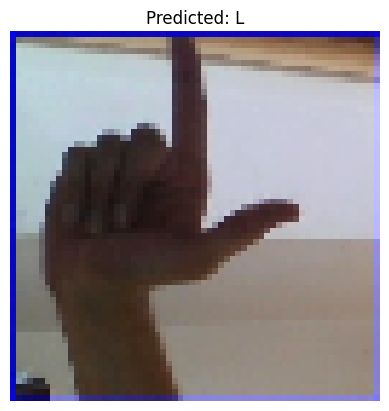

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


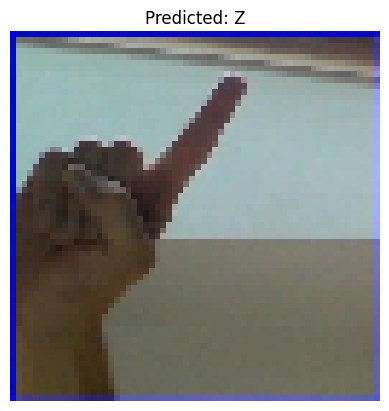

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


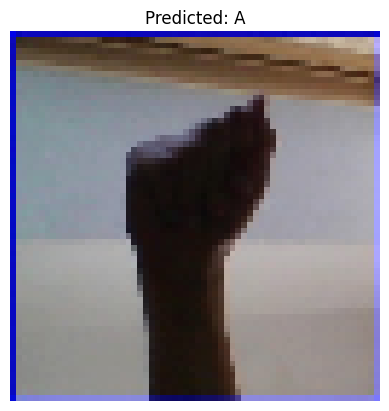

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


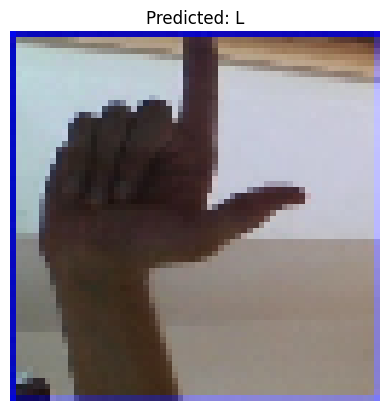

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


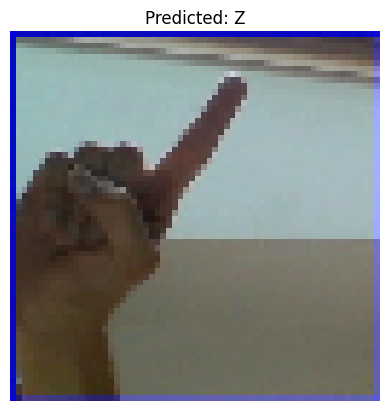

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


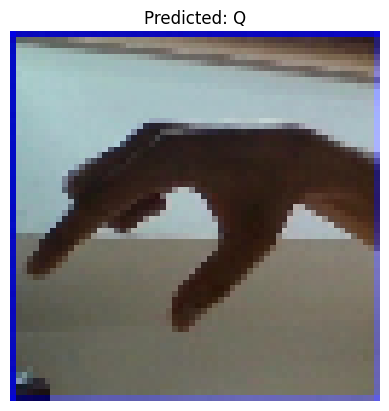

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


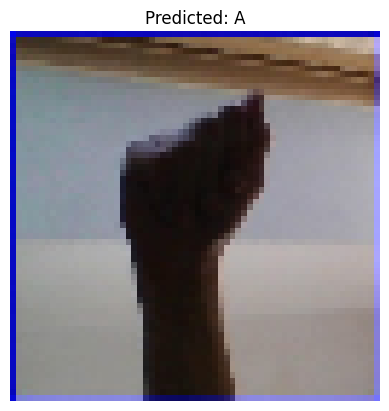

In [16]:
# Load the saved best model
model = load_model("best_model.keras")
n=10 #number of images to be tested
# Define a function to predict the class of an image and display it
def predict_and_plot_images(image_paths, model, target_size=(input_shape[0], input_shape[1]), n=10):
    i=0
    for img_path in image_paths:
        if i>=10:
            break 
        i+=1
        # Load and preprocess the image
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Predict the class
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]
        
        # Get the class label
        class_labels = list(test_generator.class_indices.keys())
        label = class_labels[predicted_class]
        
        # Plot the image with the predicted label
        plt.imshow(img)
        plt.title(f"Predicted: {label}")
        plt.axis("off")
        plt.show()


# Example usage
image_folder_path = 'ASL_dataset/test'
image_paths = [os.path.join(image_folder_path, img_name) for img_name in os.listdir(image_folder_path)]
predict_and_plot_images(image_paths, model)
